In [141]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

exp_inc_dosage = {0: 0.01, 1:0.026, 2:0.068, 3: 0.176, 4: 0.457, 5: 1.188, 6:3.089, 21: 5}
exp_dec_dosage = {0: 3.089, 1: 1.188, 2: 0.457, 3:0.176, 4:0.068, 5:0.026, 6:0.01, 21:5}
constant_dosage = {0: 0.714, 1: 0.714, 2: 0.714, 3: 0.714, 4: 0.714, 5: 0.714, 6: 0.714, 21: 5}
bolus21_dosage = {0: 5, 21: 5}
bolus28_dosage = {0: 5, 28: 5}
exp_inc_2wk_dosage = {0: 0.01, 2:0.026, 4:0.068, 6: 0.176, 8: 0.457, 10: 1.188, 12:3.089, 28: 5}
bolus_prime_exp_inc_boost_dosage = {0: 5, 28: 0.01, 30:0.026, 32:0.068, 34: 0.176, 36: 0.457, 38: 1.188, 40:3.089,}
exp_inc_prime_and_boost_dosage = {0: 0.01, 2:0.026, 4:0.068, 6: 0.176, 8: 0.457, 10: 1.188, 12:3.089, 28: 0.01, 30:0.026, 32:0.068, 34: 0.176, 36: 0.457, 38: 1.188, 40:3.089,}

def convert_to_tensor(dosage):
    arr = []
    for i in range(0, 41):
        arr.append(dosage.get(i, 0))
    return torch.tensor(arr)

dosage_dict = {"Exp-inc": convert_to_tensor(exp_inc_dosage), "Exp-dec":convert_to_tensor(exp_dec_dosage), 
            "Constant": convert_to_tensor(constant_dosage), "Bolus": convert_to_tensor(bolus21_dosage), 
            "Boost d28": convert_to_tensor(bolus28_dosage), "Exp Increase 2wk": convert_to_tensor(exp_inc_2wk_dosage), 
            "Exp Boost": convert_to_tensor(bolus_prime_exp_inc_boost_dosage), "Exp Prime/Boost": convert_to_tensor(exp_inc_prime_and_boost_dosage)}

class Data(torch.utils.data.Dataset):
    def __init__(self, dosages, results):
        self.dosages = dosages
        self.results = results
    def __len__(self):
        return len(self.results)
    def __getitem__(self, index):
        dosage = self.dosages[index]
        result = self.results[index]
        return dosage, result

data = pd.read_csv("2024-10-27 Tam 2016 Data.csv")
data = data.replace('-', np.nan)
data = data.replace("Exp Increase 1wk", "Exp-inc")
data["Binding"] = data["Binding"].astype("float32")
data["Time"] = data["Time"].transform(lambda x: int(x[3:]))
data = data.drop(data[data["Time"]>56].index)
data = data.reset_index(drop=True)
data["Subject"] = data["Subject"].transform(lambda x: int(x[6:]))

for i in range(len(data)):
    if math.isnan(data.iloc[i, data.columns.get_loc("Binding")]):
        time = int(data.iloc[i, data.columns.get_loc("Time")])
        dosing = str(data.iloc[i, data.columns.get_loc("Vaccine Scheme")])
        mean = data[(data["Time"]==time) & (data["Vaccine Scheme"]==dosing)]["Binding"].mean()
        data.loc[i, ["Binding"]] = mean

dosages = data.groupby("Subject")["Vaccine Scheme"].nth(0)
dosages = [dosage_dict[x] for x in dosages.to_list()]
results = data.groupby("Subject")["Binding"].apply(list)
results = [torch.tensor(x) for x in results.to_list()]

epoch 1, loss 15699.971447753906
epoch 2, loss 15629.37661743164
epoch 3, loss 15508.65493774414
epoch 4, loss 15256.077099609374
epoch 5, loss 14735.13182373047
epoch 6, loss 13755.60219116211
epoch 7, loss 12253.517449951172
epoch 8, loss 10530.325927734375
epoch 9, loss 9017.06690673828
epoch 10, loss 7804.019906616211
epoch 11, loss 6819.526525878906
epoch 12, loss 6027.020346069336
epoch 13, loss 5424.8068572998045
epoch 14, loss 4998.5294738769535
epoch 15, loss 4715.369250488281
epoch 16, loss 4527.649517822266
epoch 17, loss 4381.518817138672
epoch 18, loss 4244.088104248047
epoch 19, loss 4119.728137207031
epoch 20, loss 4012.1568145751953
epoch 21, loss 3913.6881896972654
epoch 22, loss 3820.782830810547
epoch 23, loss 3732.2242797851563
epoch 24, loss 3647.782574462891
epoch 25, loss 3563.749365234375
epoch 26, loss 3476.239611816406
epoch 27, loss 3394.1884826660157
epoch 28, loss 3320.1386993408205
epoch 29, loss 3250.8068908691407
epoch 30, loss 3177.6349914550783
epoch 3

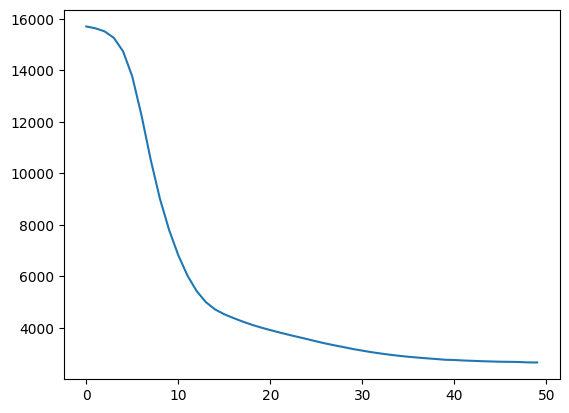

In [142]:
class RegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(torch.nn.LazyLinear(64), torch.nn.ReLU(), torch.nn.LazyLinear(8))

    def forward(self, x):
        return self.net(x)

def train(model, data, epochs, lr):
    dataloader = iter(data)
    lossFunction = torch.nn.MSELoss(reduction="mean")
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    prevLoss = float("inf")

    losses = []
    for i in range(1, epochs+1):
        epoch_loss = 0
        for batch in data:
            features, labels = batch
            optimizer.zero_grad()
            y_pred = model(features)
            
            loss = lossFunction(y_pred, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        losses.append(epoch_loss/len(data))
        print('epoch {}, loss {}'.format(i, epoch_loss/len(data)))

        if(epoch_loss>prevLoss):
            print("Stopped early on epoch {}".format(i))
            break
        prevLoss = epoch_loss
    
    plt.plot(range(len(losses)), losses)
    plt.show()
    

model = RegressionModel()

dataset = Data(dosages, results)
batch_size = 16
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

train(model=model, data=dataloader, epochs=50, lr=0.0005)

In [158]:
means = data.groupby(["Vaccine Scheme", "Time"])["Binding"].mean()
dosages = []
results = []
result = []
for index, value in means.items():
    if index[1]==7:
        dosages.append(dosage_dict[index[0]])
        results.append(result)
        result = []
    result.append(value)

test_data = Data(dosages, results[1:])
test_data = 

[[], [0.3400985300540924, 1.2060257196426392, 0.7524263858795166, 5.221281051635742, 7.810295581817627, 7.998143196105957, 9.859258651733398, 12.050553321838379], [1.7431902885437012, 6.533271789550781, 4.421821594238281, 3.4057838916778564, 35.27384948730469, 44.330509185791016, 43.102561950683594, 41.88279342651367], [0.22990301251411438, 4.251425743103027, 2.5467658042907715, 12.3991117477417, 13.663043022155762, 11.814794540405273, 14.975339889526367, 14.412280082702637], [4.21398401260376, 18.863876342773438, 15.602556228637695, 18.4449462890625, 19.55038070678711, 98.9395751953125, 197.32986450195312, 155.03285217285156], [1.720199465751648, 62.35908889770508, 44.42269515991211, 35.95026779174805, 180.19924926757812, 182.96693420410156, 171.74769592285156, 218.67132568359375], [0.616155743598938, 102.98226165771484, 110.774169921875, 39.44280242919922, 38.949424743652344, 693.276123046875, 635.7588500976562, 461.91876220703125], [0.15171439945697784, 0.8268383741378784, 0.6827899